# Computational Tests

This notebook is intended for running different kinds of analyses that would validate our reconstruction and would compare it woth previous CHO Recons

## 1.Blocked reactions in each subsystem subsystem
Here we calculate the percentage of blocked reactions in each one of our subsystems and then we compare it with previous reconstructions (iCHO1766 and iCHO2101). To calculate this value we use the .txt file generated in the **Final CHO Model** notebook **Section 2.1**

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from cobra.io import load_json_model

In [3]:
model = load_json_model('iCHOv3_CHO_02112023.json')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-24


### 1.1 Calculate the parcentage of blocked reactions per Subsystem

In [4]:
blocked_reactions = pd.read_csv('temp/Blocked_Reactions.csv')
blocked_reactions = list(blocked_reactions['Reaction'])

In [5]:
##### ----- Print the amount and total amount of blocked reactions ----- #####            
print('##### ----- Blocked Reactions ----- #####')
print(f'The model has {len(model.reactions)} total reactions')
print(f'The model has {len(blocked_reactions)} ({round(len(blocked_reactions)/len(model.reactions)*100)}%) blocked reactions')

##### ----- Blocked Reactions ----- #####
The model has 11195 total reactions
The model has 2725 (24%) blocked reactions


In [6]:
#### --- Calculate the percentage of blocked reactions per Subsystem ---- ####
blocked_subs = []
for blocked in blocked_reactions:
    blocked_rxn = model.reactions.get_by_id(blocked)
    blocked_subs.append(blocked_rxn.subsystem)
    
counter_blocked = Counter(blocked_subs)

all_subs = []
for rxn in model.reactions:
    all_subs.append(rxn.subsystem)
counter_all = Counter(all_subs)
counter_all

# calculating percentages
percentages = {}

for subsystem in counter_all.keys():
    if subsystem in counter_blocked:
        percentages[subsystem] = (counter_blocked[subsystem] / counter_all[subsystem]) * 100
    else:
        percentages[subsystem] = 0
        
# Sort the dictionary by value in descending order
sorted_percentages = {k: v for k, v in sorted(percentages.items(), key=lambda item: item[1], reverse=True)}

for k, v in sorted_percentages.items():
    print(f"{k}: {v}%")

O-GLYCAN METABOLISM: 100.0%
VITAMIN B12 METABOLISM: 100.0%
VITAMIN E METABOLISM: 100.0%
VITAMIN K METABOLISM: 100.0%
CYP METABOLISM: 100.0%
GLYCOSYLPHOSPHATIDYLINOSITOL (GPI)-ANCHOR BIOSYNTHESIS: 100.0%
LINOLEATE METABOLISM: 100.0%
LIPOATE METABOLISM: 100.0%
AMINO ACID DERIVATIVE: 100.0%
XENOBIOTICS METABOLISM: 92.38095238095238%
ARACHIDONIC ACID METABOLISM: 85.15625%
GLYCAN AND GLYCOSAMINOGLYCAN METABOLISM: 85.0%
PROTEIN DEGRADATION: 77.77777777777779%
PROTEIN ASSEMBLY: 76.19047619047619%
EICOSANOID METABOLISM: 75.98425196850394%
STILBENE, COUMARINE AND LIGNIN SYNTHESIS: 75.0%
SELENOAMINO ACID METABOLISM: 73.91304347826086%
ALKALOID SYNTHESIS: 71.42857142857143%
LIMONENE AND PINENE DEGRADATION: 70.0%
VITAMIN D METABOLISM: 67.64705882352942%
ANDROGEN AND ESTROGEN SYNTHESIS AND METABOLISM: 67.44186046511628%
METHIONINE METABOLISM: 66.66666666666666%
N-GLYCAN METABOLISM: 66.66666666666666%
INTRACELLULAR SOURCE/SINK: 66.66666666666666%
GLYCEROPHOSPHOLIPID METABOLISM: 63.59223300970874%
PE

### 1.2 Compare and plot the percentage of blocked reactions between iCHO1766, iCHO2101 and our reconstruction

In [9]:
icho1766_icho2101 = pd.read_excel('../Data/Reconciliation/datasets/iCHO2101.xlsx', 'Supplementary Table 9', header = 1)
icho1766_icho2101['Name of the metabolic pathway'] = icho1766_icho2101['Name of the metabolic pathway'].str.replace("'","")
# Now converting the dataframe to dictionary
data_dict = icho1766_icho2101[['Percent of blockage in iCHO1766', 'Percent of blockage in iCHO2101']].to_dict()
pathway_names = list(icho1766_icho2101['Name of the metabolic pathway'])

# your original dictionaries
blockage_iCHO1766 = data_dict['Percent of blockage in iCHO1766']
blockage_iCHO2101 = data_dict['Percent of blockage in iCHO2101']

# initialize new dictionaries
new_blockage_iCHO1766 = {}
new_blockage_iCHO2101 = {}

# fill the new dictionaries with the correct keys
for i, pathway in enumerate(pathway_names):
    new_blockage_iCHO1766[pathway] = blockage_iCHO1766[i]
    new_blockage_iCHO2101[pathway] = blockage_iCHO2101[i]

In [10]:
# initialize lists to hold subsystems with lower and higher values in percentages_filtered
lower_subsystems = []
higher_subsystems = []

# loop through each subsystem
for subsystem in pathway_names:
    # get the value from each dictionary, or default to 0 if the subsystem is not present
    value_percentages = percentages.get(subsystem, 0)
    value_iCHO1766 = new_blockage_iCHO1766.get(subsystem, 0)
    value_iCHO2101 = new_blockage_iCHO2101.get(subsystem, 0)
    
    # check if value_percentages_filtered is lower than both of the other values
    if value_percentages < min(value_iCHO1766, value_iCHO2101):
        lower_subsystems.append(subsystem)
    
    # check if value_percentages_filtered is higher than both of the other values
    if value_percentages > max(value_iCHO1766, value_iCHO2101):
        higher_subsystems.append(subsystem)

# print the results
print("Subsystems where 'percentages_filtered' is lower:")
for subsystem in lower_subsystems:
    print(subsystem)

print("\nSubsystems where 'percentages_filtered' is higher:")
for subsystem in higher_subsystems:
    print(subsystem)


Subsystems where 'percentages_filtered' is lower:
N-GLYCAN SYNTHESIS
FATTY ACID SYNTHESIS
GALACTOSE METABOLISM
TRIACYLGLYCEROL SYNTHESIS
XENOBIOTICS METABOLISM
NUCLEOTIDE INTERCONVERSION
NUCLEOTIDES
PENTOSE AND GLUCURONATE INTERCONVERSIONS
GLYCINE, SERINE, ALANINE AND THREONINE METABOLISM
GLYCOSPHINGOLIPID METABOLISM
PYRUVATE METABOLISM
EXCHANGE

Subsystems where 'percentages_filtered' is higher:
CYTOCHROME METABOLISM
GLYCOSYLPHOSPHATIDYLINOSITOL (GPI)-ANCHOR BIOSYNTHESIS
LIMONENE AND PINENE DEGRADATION
METHIONINE METABOLISM
PHENYLALANINE METABOLISM
PROPANOATE METABOLISM
TRANSPORT, EXTRACELLULAR
CHOLESTEROL METABOLISM
COA CATABOLISM
FRUCTOSE AND MANNOSE METABOLISM
N-GLYCAN BIOSYNTHESIS
PHOSPHATIDYLINOSITOL PHOSPHATE METABOLISM
PYRIMIDINE SYNTHESIS
SPHINGOLIPID METABOLISM
VITAMIN A METABOLISM
HISTIDINE METABOLISM
LYSINE METABOLISM
METHIONINE AND CYSTEINE METABOLISM
VALINE, LEUCINE, AND ISOLEUCINE METABOLISM
AMINOSUGAR METABOLISM
COA SYNTHESIS
FOLATE METABOLISM
GLYCEROPHOSPHOLIPID METABO

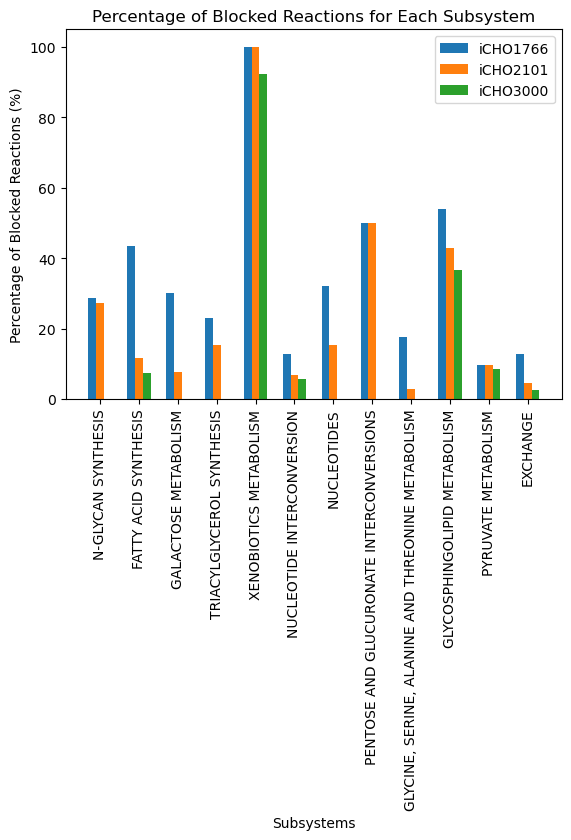

In [11]:
# List of subsystems for which we want to plot histogram
subsystems = lower_subsystems

# Create new lists with the percentages for each subsystem in each dictionary
values_icho1766 = [new_blockage_iCHO1766.get(subsystem, 0) for subsystem in subsystems]
values_icho2101 = [new_blockage_iCHO2101.get(subsystem, 0) for subsystem in subsystems]
percentages_values = [percentages.get(subsystem, 0) for subsystem in subsystems]

# Define the width of each bar and the positions of the bars
bar_width = 0.2
index = np.arange(len(subsystems))

# Create the bar plot
fig, ax = plt.subplots()

bar1 = ax.bar(index, values_icho1766, bar_width, label='iCHO1766')
bar2 = ax.bar(index + bar_width, values_icho2101, bar_width, label='iCHO2101')
bar3 = ax.bar(index + 2*bar_width, percentages_values, bar_width, label='iCHO3000')

ax.set_xlabel('Subsystems')
ax.set_ylabel('Percentage of Blocked Reactions (%)')
ax.set_title('Percentage of Blocked Reactions for Each Subsystem')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(subsystems, rotation=90)
ax.legend()

plt.show()


#### Auxotrophies

In [1]:
from cobra.io import load_json_model
iCHO_path = "iCHOv3_CHO_02112023.json"
iCHO = load_json_model(iCHO_path)

In [120]:
amino_acids = {
    # "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    # "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e"],
    # "histidine": ["EX_his_L_e", "EX_his_D_e"],
    # "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    # "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    # "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    # "methionine": ["EX_met_L_e", "EX_met_D_e"],
    # "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    # "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    # "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    # "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    # "valine": ["EX_val_L_e", "EX_val_D_e"]
}
for amino_acid in amino_acids:
    # ----- Setup initial bounds -----
    for exchange_reaction in iCHO.exchanges:
        exchange_reaction.bounds = -10, 10

    # Arginine
    iCHO.reactions.get_by_id('GAUGE-R00557').bounds = 0, 10
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R00558').bounds = 0, 0
    iCHO.reactions.get_by_id('GLYAMDTRc').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('ARGSL').bounds = 0, 0

    # Asparigine
    iCHO.reactions.get_by_id('ASNS1').bounds = 0, 0

    # Cysteine
    iCHO.reactions.get_by_id('r0129').bounds = 0, 0

    # Histidine
    iCHO.reactions.get_by_id('VALTRPVALr').bounds = 0,0 
    
    # Isoleucine
    # http://bigg.ucsd.edu/universal/reactions/RE0936C

    # Leucine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 

    # Lysine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 

    # Methionine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 

    # Phenylalanine
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_pheleu_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_glyphe_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE2917_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5789_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_phpyr_e').bounds = 0, 0 

    # Proline
    iCHO.reactions.get_by_id('EX_glypro_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_progly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('P5CR').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRxm').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRx').bounds = 0, 0
    iCHO.reactions.get_by_id('r1453').bounds = 0, 10

    # Threonine
    iCHO.reactions.get_by_id('THRS').bounds = 0,0 

    # Tryptophan
    iCHO.reactions.get_by_id('NBAHH_ir').bounds = 0,0  

    # Valine
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_vallystyr_e').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTA').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTAm').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_valval_e').bounds = 0, 10
    # -----------------------------------------

    for exchange_reaction in iCHO.exchanges:
        if exchange_reaction.id in amino_acids[amino_acid]:
            exchange_reaction.bounds = 0, 10
            print(amino_acid, exchange_reaction.id, amino_acids[amino_acid])
    sol = iCHO.optimize()
    print(amino_acid, sol.objective_value)


cysteine EX_cys_L_e ['EX_cys_L_e', 'EX_cys_D_e']
cysteine 9.598458103690223


In [119]:
iCHO.metabolites.cgly_c.summary()

Percent,Flux,Reaction,Definition
100.00%,2.277,r0129,gthrd_c + h2o_c --> cgly_c + glu_L_c
Percent,Flux,Reaction,Definition
100.00%,-2.277,AMPTASECG,cgly_c + h2o_c --> cys_L_c + gly_c


In [121]:
iCHO.metabolites.cys_L_c.summary()

Percent,Flux,Reaction,Definition
64.60%,1.471,AMPTASECG,cgly_c + h2o_c --> cys_L_c + gly_c
35.40%,0.806,r0027,2.0 cys_L_c + nadp_c <=> Lcystin_c + h_c + nadph_c
Percent,Flux,Reaction,Definition
35.03%,-0.7975,CYSTRS,atp_c + cys_L_c + trnacys_c --> amp_c + cystrna_c + ppi_c
64.97%,-1.479,r1402,22.0 ala_L_c + 12.0 arg_L_c + 12.0 asn_L_c + 26.0 asp_L_c + 1400.0 atp_c + 6.0 cys_L_c + 14.0 gln_L_c + 15.0 glu_L_c + 18.0 gly_c + 1400.0 h2o_c + 9.0 his_L_c + 12.0 ile_L_c + 39.0 leu_L_c + 18.0 lys_L_c + 8.0 met_L_c + 20.0 phe_L_c + 15.0 pro_L_c + 31.0 ser_L_c + 25.0 thr_L_c + 7.0 trp_L_c + 13.0 tyr_L_c + 28.0 val_L_c --> 1050.0 adp_c + 350.0 amp_c + ggn_c + 1050.0 pi_c + 350.0 ppi_c


In [2]:
amino_acids = {
    "alanine": ["EX_ala_B_e", "EX_ala_L_e", "EX_ala_D_e"],
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "aspartic acid": ["EX_asp_L_e", "EX_asp_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e"],
    "glutamine": ["EX_gln_L_e", "EX_gln_D_e"],
    "glutamic acid": ["EX_glu_L_e", "EX_glu_D_e"],
    "glycine": ["EX_gly_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "serine": ["EX_ser_L_e", "EX_ser_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "tyrosine": ["EX_tyr_L_e", "EX_tyr_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}

def test_auxotrophy(model, amino_acids):
    # Iterate through each amino acid and its corresponding exchange reactions
    for amino_acid, reactions in amino_acids.items():
        # Set the bounds for each exchange reaction
        for exchange in model.exchanges:
            if exchange.id in reactions:
                exchange.bounds = (0, 10)  # Allow secretion but not uptake
            else:
                exchange.bounds = (-10, 10)  # Allow uptake and secretion

        # Optimize the model for the current setup
        solution = model.optimize()
        if solution.status == "optimal":
            print(f"{amino_acid} biomass production: {solution.objective_value}")
        else:
            print(f"{amino_acid} optimization failed: {solution.status}")

In [3]:
test_auxotrophy(iCHO, amino_acids)

alanine biomass production: 22.283601163649653
arginine biomass production: 22.283601163649653
asparagine biomass production: 22.283601163649653
aspartic acid biomass production: 22.283601163649653
cysteine biomass production: 22.283601163649653
glutamine biomass production: 22.283601163649653
glutamic acid biomass production: 22.283601163649653
glycine biomass production: 22.283601163649653
histidine biomass production: 22.283601163649653
isoleucine biomass production: 22.283601163649653
leucine biomass production: 22.283601163649653
lysine biomass production: 22.283601163649653
methionine biomass production: 22.283601163649653
phenylalanine biomass production: 22.283601163649653
proline biomass production: 22.283601163649653
serine biomass production: 22.283601163649653
threonine biomass production: 11.141800581824825
tryptophan biomass production: 22.283601163649646
tyrosine biomass production: 22.283601163649646
valine biomass production: 22.283601163649646


In [16]:
iCHO.metabolites.leu_L_c.summary()

Percent,Flux,Reaction,Definition
31.40%,10,GLYLEUHYDROc,glyleu_c + h2o_c --> gly_c + leu_L_c
19.58%,6.236,LEUGLYHYc,h2o_c + leugly_c <=> gly_c + leu_L_c
17.61%,5.608,LEUtec,leu_L_e <=> leu_L_c
31.40%,10,PHELEUr,h2o_c + pheleu_c <=> leu_L_c + phe_L_c
Percent,Flux,Reaction,Definition
29.90%,-9.522,LEUTRS,atp_c + leu_L_c + trnaleu_c --> amp_c + leutrna_c + ppi_c
70.10%,-22.32,r1402,22.0 ala_L_c + 12.0 arg_L_c + 12.0 asn_L_c + 26.0 asp_L_c + 1400.0 atp_c + 6.0 cys_L_c + 14.0 gln_L_c + 15.0 glu_L_c + 18.0 gly_c + 1400.0 h2o_c + 9.0 his_L_c + 12.0 ile_L_c + 39.0 leu_L_c + 18.0 lys_L_c + 8.0 met_L_c + 20.0 phe_L_c + 15.0 pro_L_c + 31.0 ser_L_c + 25.0 thr_L_c + 7.0 trp_L_c + 13.0 tyr_L_c + 28.0 val_L_c --> 1050.0 adp_c + 350.0 amp_c + ggn_c + 1050.0 pi_c + 350.0 ppi_c


#### Matrix Sparsity

#### Gene Deletion test

##### Essential for growth genes and comparison to (An optimised genome-wide, virus free CRISPR screen for mammalian cells)

##### Commparsion to other models

#### Biomass prediction using exp. data (TODO)